<a href="https://colab.research.google.com/github/ccrodriguez27/Sentiment-Analysis-of-IMDB-Movie-Reviews/blob/main/Sentiment_Analysis_on_IMDB_Movie_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Import Libraries

In [49]:
import pandas as pd
import numpy as np
import os

import shutil

import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import WordPunctTokenizer

import random as rnd

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
data_dir = '/content/drive/MyDrive/'
data = pd.read_csv(data_dir+'IMDB Dataset.csv')

# 2 - Importing the Data

In [18]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [23]:
data.groupby(by = 'sentiment').count()

,review
sentiment,
negative,25000
positive,25000


In [24]:
data = data.drop_duplicates()

In [25]:
data.groupby(by = 'sentiment').count()

,review
sentiment,
negative,24698
positive,24884


In [72]:
def train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    # Separate positive and negative samples
    pos_data = data[data['sentiment'] == 'positive']
    neg_data = data[data['sentiment'] == 'negative']

    # Calculate the number of samples for each split
    pos_count = len(pos_data)
    neg_count = len(neg_data)

    train_pos_count = int(pos_count * train_ratio)
    val_pos_count = int(pos_count * val_ratio)
    test_pos_count = pos_count - train_pos_count - val_pos_count

    train_neg_count = int(neg_count * train_ratio)
    val_neg_count = int(neg_count * val_ratio)
    test_neg_count = neg_count - train_neg_count - val_neg_count

    # Split the data
    train_pos = pos_data[:train_pos_count]['review'].reset_index(drop=True)
    val_pos = pos_data[train_pos_count:train_pos_count + val_pos_count]['review'].reset_index(drop=True)
    test_pos = pos_data[train_pos_count + val_pos_count:]['review'].reset_index(drop=True)

    train_neg = neg_data[:train_neg_count]['review'].reset_index(drop=True)
    val_neg = neg_data[train_neg_count:train_neg_count + val_neg_count]['review'].reset_index(drop=True)
    test_neg = neg_data[train_neg_count + val_neg_count:]['review'].reset_index(drop=True)

    # Combine data
    train_x = train_pos.tolist() + train_neg.tolist()
    val_x = val_pos.tolist() + val_neg.tolist()
    test_x = test_pos.tolist() + test_neg.tolist()

    # Set labels
    train_y = [1] * len(train_pos) + [0] * len(train_neg)
    val_y = [1] * len(val_pos) + [0] * len(val_neg)
    test_y = [1] * len(test_pos) + [0] * len(test_neg)

    return train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y, test_pos, test_neg, test_x, test_y

In [73]:
train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y, test_pos, test_neg, test_x, test_y = train_val_test_split(data, train_ratio=0.7, val_ratio=0.15)

print(f"length of train_x {len(train_x)}")
print(f"length of val_x {len(val_x)}")
print(f"length of test_x {len(test_x)}")


length of train_x 34706
length of val_x 7436
length of test_x 7440


In [30]:
stopwords_english = stopwords.words('english')
stemmer = PorterStemmer()
tokenizer = WordPunctTokenizer()

In [31]:
def process_review(review):
    '''
    Input:
        review: a string containing a review
    Output:
        review_clean: a list of words containing the processed review

    '''
    # Remove HTML tags
    review = re.sub(r'<.*?>', ' ', review)
    review = re.sub(r'[^A-Za-z0-9\s]', '', review)

    review_tokens = tokenizer.tokenize(review.lower())

    reviews_clean = []
    for word in review_tokens:
        if (word not in stopwords_english and # remove stopwords
            word not in string.punctuation): # remove punctuation

            stem_word = stemmer.stem(word) # stemming word
            reviews_clean.append(stem_word)

    return reviews_clean

In [32]:
# Try out function that processes reviews
print("original review at training position 0")
print(train_pos[1])

print("Review at training position 0 after processing:")
process_review(train_pos[1])

original review at training position 0
A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating e

['wonder',
 'littl',
 'product',
 'film',
 'techniqu',
 'unassum',
 'oldtimebbc',
 'fashion',
 'give',
 'comfort',
 'sometim',
 'discomfort',
 'sens',
 'realism',
 'entir',
 'piec',
 'actor',
 'extrem',
 'well',
 'chosen',
 'michael',
 'sheen',
 'got',
 'polari',
 'voic',
 'pat',
 'truli',
 'see',
 'seamless',
 'edit',
 'guid',
 'refer',
 'william',
 'diari',
 'entri',
 'well',
 'worth',
 'watch',
 'terrificli',
 'written',
 'perform',
 'piec',
 'master',
 'product',
 'one',
 'great',
 'master',
 'comedi',
 'life',
 'realism',
 'realli',
 'come',
 'home',
 'littl',
 'thing',
 'fantasi',
 'guard',
 'rather',
 'use',
 'tradit',
 'dream',
 'techniqu',
 'remain',
 'solid',
 'disappear',
 'play',
 'knowledg',
 'sens',
 'particularli',
 'scene',
 'concern',
 'orton',
 'halliwel',
 'set',
 'particularli',
 'flat',
 'halliwel',
 'mural',
 'decor',
 'everi',
 'surfac',
 'terribl',
 'well',
 'done']

## 2.2 Building the Vocabulary based on the training data
This is done by:

- Assigning an index to every word by iterating over the training set.
- Including special tokens, namely:
  1. **PAD**: padding
  2. <**/e**>: end of line
  3. **UNK**: a token representing any word that is not in the vocabulary.


In [33]:
# Build the vocabulary
def get_vocab(train_x):

    # Include special tokens
    # started with pad, end of line and unk tokens
    Vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2}

    # Note that we build vocab using training data
    for review in train_x:
        processed_review = process_review(review)
        for word in processed_review:
            if word not in Vocab:
                Vocab[word] = len(Vocab)

    return Vocab

In [34]:
Vocab = get_vocab(train_x)

print("Total words in vocab are",len(Vocab))
display(Vocab)

Total words in vocab are 102924


{'__PAD__': 0,
 '__</e>__': 1,
 '__UNK__': 2,
 'one': 3,
 'review': 4,
 'mention': 5,
 'watch': 6,
 '1': 7,
 'oz': 8,
 'episod': 9,
 'youll': 10,
 'hook': 11,
 'right': 12,
 'exactli': 13,
 'happen': 14,
 'first': 15,
 'thing': 16,
 'struck': 17,
 'brutal': 18,
 'unflinch': 19,
 'scene': 20,
 'violenc': 21,
 'set': 22,
 'word': 23,
 'go': 24,
 'trust': 25,
 'show': 26,
 'faint': 27,
 'heart': 28,
 'timid': 29,
 'pull': 30,
 'punch': 31,
 'regard': 32,
 'drug': 33,
 'sex': 34,
 'hardcor': 35,
 'classic': 36,
 'use': 37,
 'call': 38,
 'nicknam': 39,
 'given': 40,
 'oswald': 41,
 'maximum': 42,
 'secur': 43,
 'state': 44,
 'penitentari': 45,
 'focus': 46,
 'mainli': 47,
 'emerald': 48,
 'citi': 49,
 'experiment': 50,
 'section': 51,
 'prison': 52,
 'cell': 53,
 'glass': 54,
 'front': 55,
 'face': 56,
 'inward': 57,
 'privaci': 58,
 'high': 59,
 'agenda': 60,
 'em': 61,
 'home': 62,
 'manyaryan': 63,
 'muslim': 64,
 'gangsta': 65,
 'latino': 66,
 'christian': 67,
 'italian': 68,
 'irish': 

## 2.3 - Converting a Tweet to a Tensor


*   This function returns a list of integers representing the preocessed tweet.
*   Words not present in the dictionary are replaced with "__UNK__"



In [35]:
### Convert the reviews to a tensor ###

def convert_to_tensor(review, vocab_dict, unk_token='__UNK__', verbose=False):
    '''
    Input:
        review - A string containing the review
        vocab_dict - The words dictionary
        unk_token - The special string for unknown tokens
        verbose - Print info durign runtime
    Output:
        tensor_l - A python list with

    '''

    # Process the review into a list of words
    # where only important words are kept (stop words removed)
    word_l = process_review(review)

    if verbose:
        print("List of words from the processed review:")
        print(word_l)

    # Initialize the list that will contain the unique integer IDs of each word
    tensor_l = []

    # Get the unique integer ID of the __UNK__ token
    unk_ID = vocab_dict[unk_token]

    if verbose:
        print(f"The unique integer ID for the unk_token is {unk_ID}")

    # for each word in the list:
    for word in word_l:

        # Get the unique integer ID.
        # If the word doesn't exist in the vocab dictionary,
        # use the unique ID for __UNK__ instead.
        word_ID = vocab_dict[word] if word in vocab_dict.keys() else unk_ID

        # Append the unique integer ID to the tensor list.
        tensor_l.append(word_ID)


    return tensor_l

In [36]:
print("Actual review is\n", val_pos[0])
print("\nTensor of review:\n", convert_to_tensor(val_pos[0], vocab_dict=Vocab))

Actual review is
 The finest short I've ever seen. Some commentators suggest it might have been lengthened, due to the density of insight it offers. There's irony in that comment and little merit. The acting is all up to Noonan and he carries his thankless character perfectly. I might have preferred that the narrator be less "recognizable", but the gravitas lent is pitch perfect. This is a short for people who read, for those whose "bar" is set high and for those who recognize that living in a culture that celebrates stupidity and banality can forge contrary and bitter defenders of beauty. A beautiful short film. FWIW: I was pleased at the Picasso reference, since I once believed that Picasso was just another art whore with little talent; like, I assume, most people - until the day I saw some drawings he made when he was 12. Picasso was a finer draftsman and a brilliant artist at that age than many artists will ever become in a lifetime. I understood immediately why he had to make the 

## 2.4. Creating the batch generator
This function takes in the positive/negative tweets and returns a batch of training examples. It returns the model inputs, the targets (positive or negative labels) and the weight for each target.

In [37]:
def data_generator(data_pos, data_neg, batch_size, loop, vocab_dict, shuffle=False):
    '''
    Input:
        data_pos - Set of positive examples
        data_neg - Set of negative examples
        batch_size - number of samples per batch. Must be even
        loop - True or False
        vocab_dict - The words dictionary
        shuffle - Shuffle the data order
    Yield:
        inputs - Subset of positive and negative examples
        targets - The corresponding labels for the subset
        example_weights - A numpy array specifying the importance of each example

    '''

    # make sure the batch size is an even number
    # to allow an equal number of positive and negative samples
    assert batch_size % 2 == 0

    # Number of positive examples in each batch is half of the batch size
    # same with number of negative examples in each batch
    n_to_take = batch_size // 2

    # Use pos_index to walk through the data_pos array
    # same with neg_index and data_neg
    pos_index = 0
    neg_index = 0

    len_data_pos = len(data_pos)
    len_data_neg = len(data_neg)

    # Get and array with the data indexes
    pos_index_lines = list(range(len_data_pos))
    neg_index_lines = list(range(len_data_neg))

    # shuffle lines if shuffle is set to True
    if shuffle:
        rnd.shuffle(pos_index_lines)
        rnd.shuffle(neg_index_lines)

    stop = False

    # Loop indefinitely
    while not stop:

        # create a batch with positive and negative examples
        batch = []

        # First part: Pack n_to_take positive examples

        # Start from 0 and increment i up to n_to_take
        for i in range(n_to_take):

            # If the positive index goes past the positive dataset,
            if pos_index >= len_data_pos:

                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True;
                    break;
                # If user wants to keep re-using the data, reset the index
                pos_index = 0
                if shuffle:
                    # Shuffle the index of the positive sample
                    rnd.shuffle(pos_index_lines)

            # get the tweet as pos_index
            review = data_pos[pos_index_lines[pos_index]]

            # convert the review into tensors of integers representing the processed words
            tensor = convert_to_tensor(review, vocab_dict)

            # append the tensor to the batch list
            batch.append(tensor)

            # Increment pos_index by one
            pos_index = pos_index + 1

        # Second part: Pack n_to_take negative examples

        # Using the same batch list, start from 0 and increment i up to n_to_take
        for i in range(n_to_take):

            # If the negative index goes past the negative dataset,
            if neg_index >= len_data_neg:

                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True
                    break

                # If user wants to keep re-using the data, reset the index
                neg_index = 0

                if shuffle:
                    # Shuffle the index of the negative sample
                    rnd.shuffle(neg_index_lines)

            # get the tweet as neg_index
            review = data_neg[neg_index_lines[neg_index]]

            # convert the review into tensors of integers representing the processed words
            tensor = convert_to_tensor(review, vocab_dict)

            # append the tensor to the batch list
            batch.append(tensor)

            # Increment neg_index by one
            neg_index = neg_index + 1

        ### END CODE HERE ###

        if stop:
            break;

        # Get the max tweet length (the length of the longest tweet)
        # (you will pad all shorter tweets to have this length)
        max_len = max([len(t) for t in batch])


        # Initialize the input_l, which will
        # store the padded versions of the tensors
        tensor_pad_l = []
        # Pad shorter tweets with zeros
        for tensor in batch:


            # Get the number of positions to pad for this tensor so that it will be max_len long
            n_pad = max_len - len(tensor)

            # Generate a list of zeros, with length n_pad
            pad_l = [0] * n_pad

            # concatenate the tensor and the list of padded zeros
            tensor_pad = tensor + pad_l

            # append the padded tensor to the list of padded tensors
            tensor_pad_l.append(tensor_pad)

        # convert the list of padded tensors to a numpy array
        # and store this as the model inputs
        inputs = np.array(tensor_pad_l)

        # Generate the list of targets for the positive examples (a list of ones)
        # The length is the number of positive examples in the batch
        target_pos = [1] *n_to_take

        # Generate the list of targets for the negative examples (a list of zeros)
        # The length is the number of negative examples in the batch
        target_neg = [0] *n_to_take

        # Concatenate the positve and negative targets
        target_l = target_pos + target_neg

        # Convert the target list into a numpy array
        targets = np.array(target_l)

        # Example weights: Treat all examples equally importantly.
        example_weights = np.ones_like(targets)



        # note we use yield and not return
        yield inputs, targets, example_weights

In [38]:
# Set the random number generator for the shuffle procedure
rnd.seed(30)

# Create the training data generator

def train_generator(batch_size, train_pos
                    , train_neg, vocab_dict, loop=True
                    , shuffle = False):
    return data_generator(train_pos, train_neg, batch_size, loop, vocab_dict, shuffle)

# Create the validation data generator
def val_generator(batch_size, val_pos
                    , val_neg, vocab_dict, loop=True
                    , shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, loop, vocab_dict, shuffle)

# Create the validation data generator
def test_generator(batch_size, test_pos
                    , test_neg, vocab_dict, loop=False
                    , shuffle = False):
    return data_generator(test_pos, test_neg, batch_size, loop, vocab_dict, shuffle)

# Get a batch from the train_generator and inspect.
inputs, targets, example_weights = next(train_generator(4, train_pos, train_neg, Vocab, shuffle=True))

# this will print a list of 4 tensors padded with zeros
print(f'Inputs: {inputs}')
print(f'Targets: {targets}')
print(f'Example Weights: {example_weights}')

Inputs: [[  282   187   699   246     3   322  2577   282   755   248   101   364
    329  2536   248   364  3656   236  2714  1237   244   243  2765   190
   3007  1237   268  2558  2765   282  1201   324 46236   141   529  1527
    324   248   736  7273 22113  7446  3402  1803  1200   248   364  8889
     36   282  1463   282    36   221   848 17238   951  1883   529  2765
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [  529    98   526  3020  5393 19371   754     3  1405   282   206   416
   1569  2115  3017   252  1803 14932 19702   520  2961   306  2001   206
      3  2300   144   576  1612   915  4443 19371   754   499  2061  1719
    685 17947    72   976  1686  1244 15256   7

# 3 - Model Creation

In [40]:
# !pip install trax

In [39]:
import trax
from trax.supervised import training
import trax.fastmath.numpy as np
from trax import layers as tl
from trax import fastmath

In [41]:
# Layers have weights and a forward function.
# They create weights when layer.initialize is called and use them.

class Layer(object):
    """Base class for layers."""
    def __init__(self):
        self.weights = None

    # initializes the weights based on the input signature and random key
    def forward(self, x):
        raise NotImplementedError

    # initializes and returns the weights
    def init_weights_and_state(self, input_signature, random_key):
        pass

    def init(self, input_signature, random_key):
        self.init_weights_and_state(input_signature, random_key)
        return self.weights

    def __call__(self, x):
        return self.forward(x)


class Relu(Layer):
    """Relu activation function implementation"""
    def forward(self, x):
        '''
        Input:
            - x (a numpy array): the input
        Output:
            - activation (numpy array): all positive or 0 version of x
        '''

        activation = np.maximum(x, 0)

        return activation

In [42]:
class Dense(Layer):
    """
    A dense (fully-connected) layer.
    """

    def __init__(self, n_units, init_stdev=0.1):

        # Set the number of units in this layer
        self._n_units = n_units
        self._init_stdev = init_stdev

    # Matrix multiply x and the weight matrix
    def forward(self, x):

        dense = np.dot(x, self.weights)

        return dense

    # init_weights
    def init_weights_and_state(self, input_signature, random_key):

        # The input_signature has a .shape attribute that gives the shape as a tuple

        input_shape = input_signature.shape

        # Generate the weight matrix from a normal distribution,
        # and standard deviation of 'stdev'
        w = 0.1 * trax.fastmath.random.normal(key = random_key, shape = (input_shape[-1], self._n_units))

        self.weights = w
        return self.weights

In [59]:
def classifier(vocab_size=102924, embedding_dim=300, output_dim=2, mode='train'):

    # create embedding layer
    embed_layer = tl.Embedding(
        vocab_size=vocab_size, # Size of the vocabulary
        d_feature=embedding_dim # Embedding dimension
    )

    # Create a mean layer, to create an "average" word embedding
    mean_layer = tl.Mean(axis=1)

    # Create a dense layer, one unit for each output
    dense_output_layer = tl.Dense(n_units = output_dim)

    # Use tl.Serial to combine all layers
    # and create the classifier
    # of type trax.layers.combinators.Serial
    model = tl.Serial(
      embed_layer, # embedding layer
      mean_layer, # mean layer
      dense_output_layer # dense output layer
    )

    # return the model of type
    return model

In [60]:
def get_train_eval_tasks(train_pos, train_neg, val_pos, val_neg, vocab_dict, loop, batch_size = 16):

    rnd.seed(271)

    train_task = training.TrainTask(
        labeled_data=train_generator(batch_size, train_pos
                    , train_neg, vocab_dict, loop
                    , shuffle = True),
        loss_layer=tl.WeightedCategoryCrossEntropy(),
        optimizer=trax.optimizers.Adam(0.01),
        n_steps_per_checkpoint=10,
    )

    eval_task = training.EvalTask(
        labeled_data=val_generator(batch_size, val_pos
                    , val_neg, vocab_dict, loop
                    , shuffle = True),
        metrics=[tl.WeightedCategoryCrossEntropy(), tl.WeightedCategoryAccuracy()],
    )

    return train_task, eval_task

In [61]:
train_task, eval_task = get_train_eval_tasks(train_pos, train_neg, val_pos, val_neg, Vocab, True, batch_size = 16)
model = classifier()

In [62]:
def train_model(classifier, train_task, eval_task, n_steps, output_dir):
    '''
    Input:
        classifier - the model you are building
        train_task - Training task
        eval_task - Evaluation task. Received as a list.
        n_steps - the evaluation steps
        output_dir - folder to save your files
    Output:
        trainer -  trax trainer
    '''
    rnd.seed(31)

    training_loop = training.Loop(
                                classifier, # The learning model
                                train_task, # The training task
                                eval_tasks=eval_task, # The evaluation task
                                output_dir=output_dir, # The output directory
                                random_seed=31
    )

    training_loop.run(n_steps = n_steps)

    # Return the training_loop, since it has the model.
    return training_loop

In [63]:
dir_path = './model/'

try:
    shutil.rmtree(dir_path)
except OSError as e:
    pass


output_dir = './model/'
output_dir_expand = os.path.expanduser(output_dir)
print(output_dir_expand)

./model/


In [64]:
training_loop = train_model(model, train_task, [eval_task], 100, output_dir_expand)


Step      1: Total number of trainable weights: 30877802
Step      1: Ran 1 train steps in 10.53 secs
Step      1: train WeightedCategoryCrossEntropy |  0.69318092
Step      1: eval  WeightedCategoryCrossEntropy |  0.69267797
Step      1: eval      WeightedCategoryAccuracy |  0.56250000

Step     10: Ran 9 train steps in 18.16 secs
Step     10: train WeightedCategoryCrossEntropy |  0.69842875
Step     10: eval  WeightedCategoryCrossEntropy |  0.69015151
Step     10: eval      WeightedCategoryAccuracy |  0.50000000

Step     20: Ran 10 train steps in 19.38 secs
Step     20: train WeightedCategoryCrossEntropy |  0.69283170
Step     20: eval  WeightedCategoryCrossEntropy |  0.68016803
Step     20: eval      WeightedCategoryAccuracy |  0.50000000

Step     30: Ran 10 train steps in 17.23 secs
Step     30: train WeightedCategoryCrossEntropy |  0.67948288
Step     30: eval  WeightedCategoryCrossEntropy |  0.64852333
Step     30: eval      WeightedCategoryAccuracy |  0.56250000

Step     40:

In [67]:
def compute_accuracy(preds, y, y_weights):
    """
    Input:
        preds: a tensor of shape (dim_batch, output_dim)
        y: a tensor of shape (dim_batch,) with the true labels
        y_weights: a n.ndarray with the a weight for each example
    Output:
        accuracy: a float between 0-1
        weighted_num_correct (np.float32): Sum of the weighted correct predictions
        sum_weights (np.float32): Sum of the weights
    """
    # Create an array of booleans,
    # True if the probability of positive sentiment is greater than
    # the probability of negative sentiment
    # else False
    is_pos = preds[:, 1] > preds[:, 0]

    # convert the array of booleans into an array of np.int32
    is_pos_int = is_pos.astype(np.int32)

    # compare the array of predictions (as int32) with the target (labels) of type int32
    correct = is_pos_int == y

    # Count the sum of the weights.
    sum_weights = np.sum(y_weights)

    # convert the array of correct predictions (boolean) into an arrayof np.float32
    correct_float = correct.astype(np.float32)

    # Multiply each prediction with its corresponding weight.
    weighted_correct_float = correct_float * y_weights

    # Sum up the weighted correct predictions (of type np.float32), to go in the
    # numerator.
    weighted_num_correct = np.sum(weighted_correct_float)

    # Divide the number of weighted correct predictions by the sum of the
    # weights.
    accuracy = weighted_num_correct / sum_weights

    return accuracy, weighted_num_correct, sum_weights

In [136]:
def test_model(generator, model, compute_accuracy=compute_accuracy):
    '''
    Input:
        generator: an iterator instance that provides batches of inputs and targets
        model: a model instance
    Output:
        accuracy: float corresponding to the accuracy
    '''

    accuracy = 0
    total_num_correct = 0
    total_num_pred = 0

    all_pred = []
    all_targets = []
    batch_size = []


    for batch in generator:
        batch_size.append(len(batch[0]))
        # Retrieve the inputs from the batch
        inputs =  batch[0]

        # Retrieve the targets (actual labels) from the batch
        targets = batch[1]
        all_targets.append(targets)

        # Retrieve the example weight.
        example_weight = batch[2]

        # Make predictions using the inputs
        pred = model(inputs)
        all_pred.append(pred)

        # Calculate accuracy for the batch by comparing its predictions and targets
        batch_accuracy, batch_num_correct, batch_num_pred = compute_accuracy(pred, targets, example_weight)

        # Update the total number of correct predictions
        # by adding the number of correct predictions from this batch
        total_num_correct += batch_num_correct

        # Update the total number of predictions
        # by adding the number of predictions made for the batch
        total_num_pred += batch_num_pred

    # Calculate accuracy over all examples
    accuracy = total_num_correct / total_num_pred


    return all_pred, all_targets, batch_size, accuracy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [171]:
train_pred, train_targets, train_batch_size, train_accuracy  = test_model(train_generator(10, train_pos
                    , train_neg, Vocab, loop=False
                    , shuffle = False), model)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [170]:
print(f"The model's accuracy on the training set is {train_accuracy[0]}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Array(0.7722881, dtype=float32)

In [137]:
model = training_loop.eval_model
pred, targets, batch_size, accuracy = test_model(test_generator(10, test_pos
                    , test_neg, Vocab, loop=False
                    , shuffle = False), model)

print(f'The accuracy of your model on the test set is {accuracy:.4f}', )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The accuracy of your model on the test set is 0.7613


In [143]:
sum(batch_size)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7410

In [144]:
binary_pred = []
for array in pred:
    tmp_is_positive = array[:, 1] > array[:, 0]
    tmp_is_positive_01 = [1 if val else 0 for val in tmp_is_positive]
    binary_pred = binary_pred + tmp_is_positive_01

In [115]:
test_targets = [item for sublist in targets for item in sublist]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [145]:
test_set = pd.DataFrame({
    'review': test_x[:7410],
    'pred': binary_pred,
    'actual': test_targets
})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [168]:
test_set

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,review,pred,actual
0,Count me as being one who is happy to see no H...,0,1
1,"I know, that's not what you expect from a film...",1,1
2,I don't care how many bad reviews purple rain ...,1,1
3,This Norwegian film starts with a man jumping ...,1,1
4,I have seen the short movie a few years ago. A...,1,1
...,...,...,...
7405,Why did the histories of Mary and Rhoda have t...,1,0
7406,"The movie is not that bad, Ringo Lam sucks. I ...",0,0
7407,"This picture started out with good intentions,...",0,0
7408,One of the greatest lessons I ever had in how ...,1,0


# 4 - Model Evaluation

In [147]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn import metrics

In [148]:
print(classification_report(binary_pred,test_targets))

              precision    recall  f1-score   support

           0       0.57      0.93      0.70      2272
           1       0.95      0.69      0.80      5138

    accuracy                           0.76      7410
   macro avg       0.76      0.81      0.75      7410
weighted avg       0.84      0.76      0.77      7410



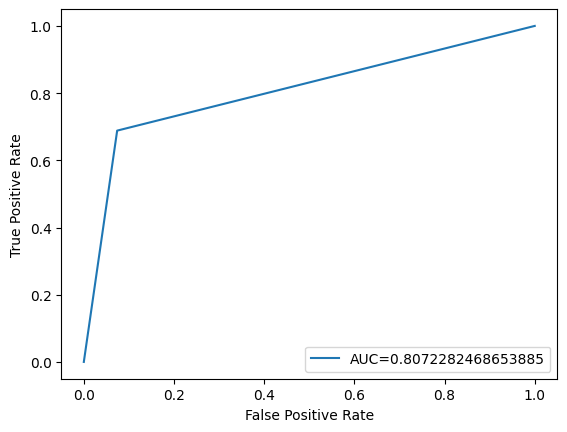

In [166]:
#define metrics
fpr, tpr, _ = metrics.roc_curve(binary_pred,  test_targets)
auc = metrics.roc_auc_score(binary_pred, test_targets)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

*   The dense neural network achieved an accuracy rate of 76.13% when classifying the test data. Among the reviews it predicted as having a positive sentiment, 95% were accurate in reality. In terms of recall, the model correctly identified 69% of the reviews that were genuinely positive.

*   Examining the F1 scores, we find that the negative class has an F1 score of 0.7, while the positive class has an F1 score of 0.8. These scores signify a well-balanced performance, where the model adeptly balances the accurate identification of class 1 instances (recall) while simultaneously minimizing false positives (precision).


*   The AUC (Area Under the Curve) is 80.72%, indicating that the model can effectively differentiate between positive and negative movie reviews approximately 80.72% of the time.

*   The model displayed an accuracy rate of 77.22% on the training set and 76.13% on the testing set, suggesting that it did not exhibit overfitting, as the performance on both sets is relatively consistent.





# 5 - Testing with new movie reviews

In [173]:
def predict(sentence):
    inputs = np.array(convert_to_tensor(sentence, vocab_dict=Vocab))

    # Batch size 1, add dimension for batch, to work with the model
    inputs = inputs[None, :]

    # predict with the model
    preds_probs = model(inputs)

    # Turn probabilities into categories
    preds = int(preds_probs[0, 1] > preds_probs[0, 0])

    sentiment = "negative"
    if preds == 1:
        sentiment = 'positive'

    return preds, sentiment


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [174]:
# try a positive review
sentence = "Even almost 15 years on this movie is still amazing to me, I remember my first time watching Meet The Robinsons i cried \
at the end because it was so heartwarming now every time I watch the movie i cry no matter how hard i try not to. \
The loving family aesthetic and the great story-line is truly wonderful a young boy searching for a mother who didn't \
want him even typing this up I'm tearing up as of now. If I had to watch one thing for my rest of my life i could happily watch \
this movie no questions asked it reminds me of how good life can be and how my life was good when i first watched it solid 10/10 !"

In [176]:
tmp_pred, tmp_sentiment = predict(sentence)
print(f"The sentiment of the sentence \n***\n\"{sentence}\"\n***\nis {tmp_sentiment}.")

The sentiment of the sentence 
***
"Even almost 15 years on this movie is still amazing to me, I remember my first time watching Meet The Robinsons i cried at the end because it was so heartwarming now every time I watch the movie i cry no matter how hard i try not to. The loving family aesthetic and the great story-line is truly wonderful a young boy searching for a mother who didn't want him even typing this up I'm tearing up as of now. If I had to watch one thing for my rest of my life i could happily watch  this movie no questions asked it reminds me of how good life can be and how my life was good when i first watched it solid 10/10 !"
***
is positive.


In [177]:
# try a negative sentence:
sentence = "Stiff acting and facial expressions.\
No conflict, she didn't have to fight for what she believes in that much, she was just accepted right away after they sent her off. \
No character development. She's already strong. She didn't even have to train properly. She just had to turn on that chi and that sucks. \
Unlikeable side characters.\ They werent close enough so it did not justify that she was accepted by them \
Random guy with romance baiting. Her dynamics with the rest of the cast was weird and unnatural and forced. \
I liked her dad and the witch lady (kinda ish) though.The fighting was so whack.\
The attempts at comedy/funny times were so weird. Especially that part where she catches everything."

tmp_pred, tmp_sentiment = predict(sentence)
print(f"The sentiment of the sentence \n***\n\"{sentence}\"\n***\nis {tmp_sentiment}.")

The sentiment of the sentence 
***
"Stiff acting and facial expressions.No conflict, she didn't have to fight for what she believes in that much, she was just accepted right away after they sent her off. No character development. She's already strong. She didn't even have to train properly. She just had to turn on that chi and that sucks. Unlikeable side characters.\ They werent close enough so it did not justify that she was accepted by them Random guy with romance baiting. Her dynamics with the rest of the cast was weird and unnatural and forced. I liked her dad and the witch lady (kinda ish) though.The fighting was so whack.The attempts at comedy/funny times were so weird. Especially that part where she catches everything."
***
is negative.


<>:2: DeprecationWarning: invalid escape sequence '\ '
